In [1]:
import datetime as dt

## Extracting Gridded Forecasts Using Siphon

In [2]:
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

In [3]:
# THREDDS base url for NCEP GFS 0.5deg operational model
baseurl = 'http://nomads.ncdc.noaa.gov/thredds/catalog/gfs-004/%s/%s/catalog.html?dataset=gfs-004/%s/%s'

In [4]:
# date of model initialization time
date = dt.datetime(2016,1,1)
# reformat date to conform with THREDDS format
month_format = dt.datetime.strftime(date, '%Y%m')
day_format = dt.datetime.strftime(date, '%Y%m%d')
thredds_url = baseurl % (month_format, day_format, month_format, day_format)

In [5]:
# get list of GFS 0.5deg grib files available for given date
gfs_gribs = TDSCatalog(thredds_url)
list(gfs_gribs.datasets)[:10]

/Users/charlie/dato-env/lib/python2.7/site-packages/siphon/catalog.py:62: UserWarning: URL http://nomads.ncdc.noaa.gov/thredds/catalog/gfs-004/201601/20160101/catalog.html?dataset=gfs-004/201601/20160101 returned HTML. Changing to: http://nomads.ncdc.noaa.gov/thredds/catalog/gfs-004/201601/20160101/catalog.xml?dataset=gfs-004/201601/20160101
  new_url))


['GFS Grid 4  2016-01-01 18:00 UTC fct:120.grb2',
 'GFS Grid 4  2016-01-01 00:00 UTC fct:120.grb2',
 'GFS Grid 4  2016-01-01 18:00 UTC fct:183.grb2',
 'GFS Grid 4  2016-01-01 00:00 UTC fct:171.grb2',
 'GFS Grid 4  2016-01-01 12:00 UTC fct:201.grb2',
 'GFS Grid 4  2016-01-01 18:00 UTC fct:102.grb2',
 'GFS Grid 4  2016-01-01 18:00 UTC fct:219.grb2',
 'GFS Grid 4  2016-01-01 00:00 UTC fct:060.grb2',
 'GFS Grid 4  2016-01-01 00:00 UTC fct:012.grb2',
 'GFS Grid 4  2016-01-01 12:00 UTC fct:300.grb2']

In [6]:
# specifiy model init time given date, and the fcst_hour (forecast horizon) of interest
init_time = '00'
fcst_hour = '024'

# generate actual grib filename
grid_name = 'GFS Grid 4  %s %s:00 UTC fct:%s.grb2' % (dt.datetime.strftime(date, '%Y-%m-%d'),  init_time, fcst_hour)

# get grib file of interest access points
grid = gfs_gribs.datasets[grid_name]

In [7]:
# use siphon's ncss class to access grid via THREDD's netcdf server
ncss = NCSS(grid.access_urls['NetcdfServer'])

# create a query of interest with boundary box, include lat lon, and query variables of interest
query = ncss.query()
query.lonlat_box(-130, -70, 20, 50)
query.add_lonlat()
query.variables( 'U-component_of_wind_height_above_ground', 
                 'V-component_of_wind_height_above_ground', )

# query the data
data = ncss.get_data(query)

In [8]:
data.variables.keys()

[u'U-component_of_wind_height_above_ground',
 u'time',
 u'height_above_ground5',
 u'lat',
 u'lon',
 u'V-component_of_wind_height_above_ground']

In [9]:
data

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    Originating_center: US National Weather Service - NCEP(WMC) (7)
    Generating_Model: Global Forecast System Model (formerly known as the Aviation)
    Product_Status: Operational products
    Product_Type: Forecast products
    title: US National Weather Service - NCEP(WMC) Global Forecast System Model (formerly known as the Aviation) Forecast products
    institution: Center US National Weather Service - NCEP(WMC) (7)
    source: Type: Forecast products Status: Operational products
    history: Direct read of GRIB-2 into NetCDF-Java 4 API
    CF:feature_type: GRID
    file_format: GRIB-2
    location: /nomads3_data/raid2/noaaport/merged/gfs4/201601/20160101/gfs_4_20160101_0000_024.grb2
    _CoordinateModelRunDate: 2016-01-01T00:00:00Z
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (NetcdfCFWriter)
Original Dataset = /nomads3_data/raid2/noaaport

In [10]:
# dimension of dataset
data['U-component_of_wind_height_above_ground'][:].squeeze().shape

(3, 61, 121)

## Plotting Using Cartopy

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

In [12]:
# parsing out data of interest from netcdf format into numpy arrays
y = data.variables['lat'][:].squeeze()
x = data.variables['lon'][:].squeeze()
u = data['U-component_of_wind_height_above_ground'][:].squeeze()[0]
v = data['V-component_of_wind_height_above_ground'][:].squeeze()[0]

In [13]:
# gfs lon are degrees from 0, so need to normalize
x = x - 360

/Users/charlie/dato-env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


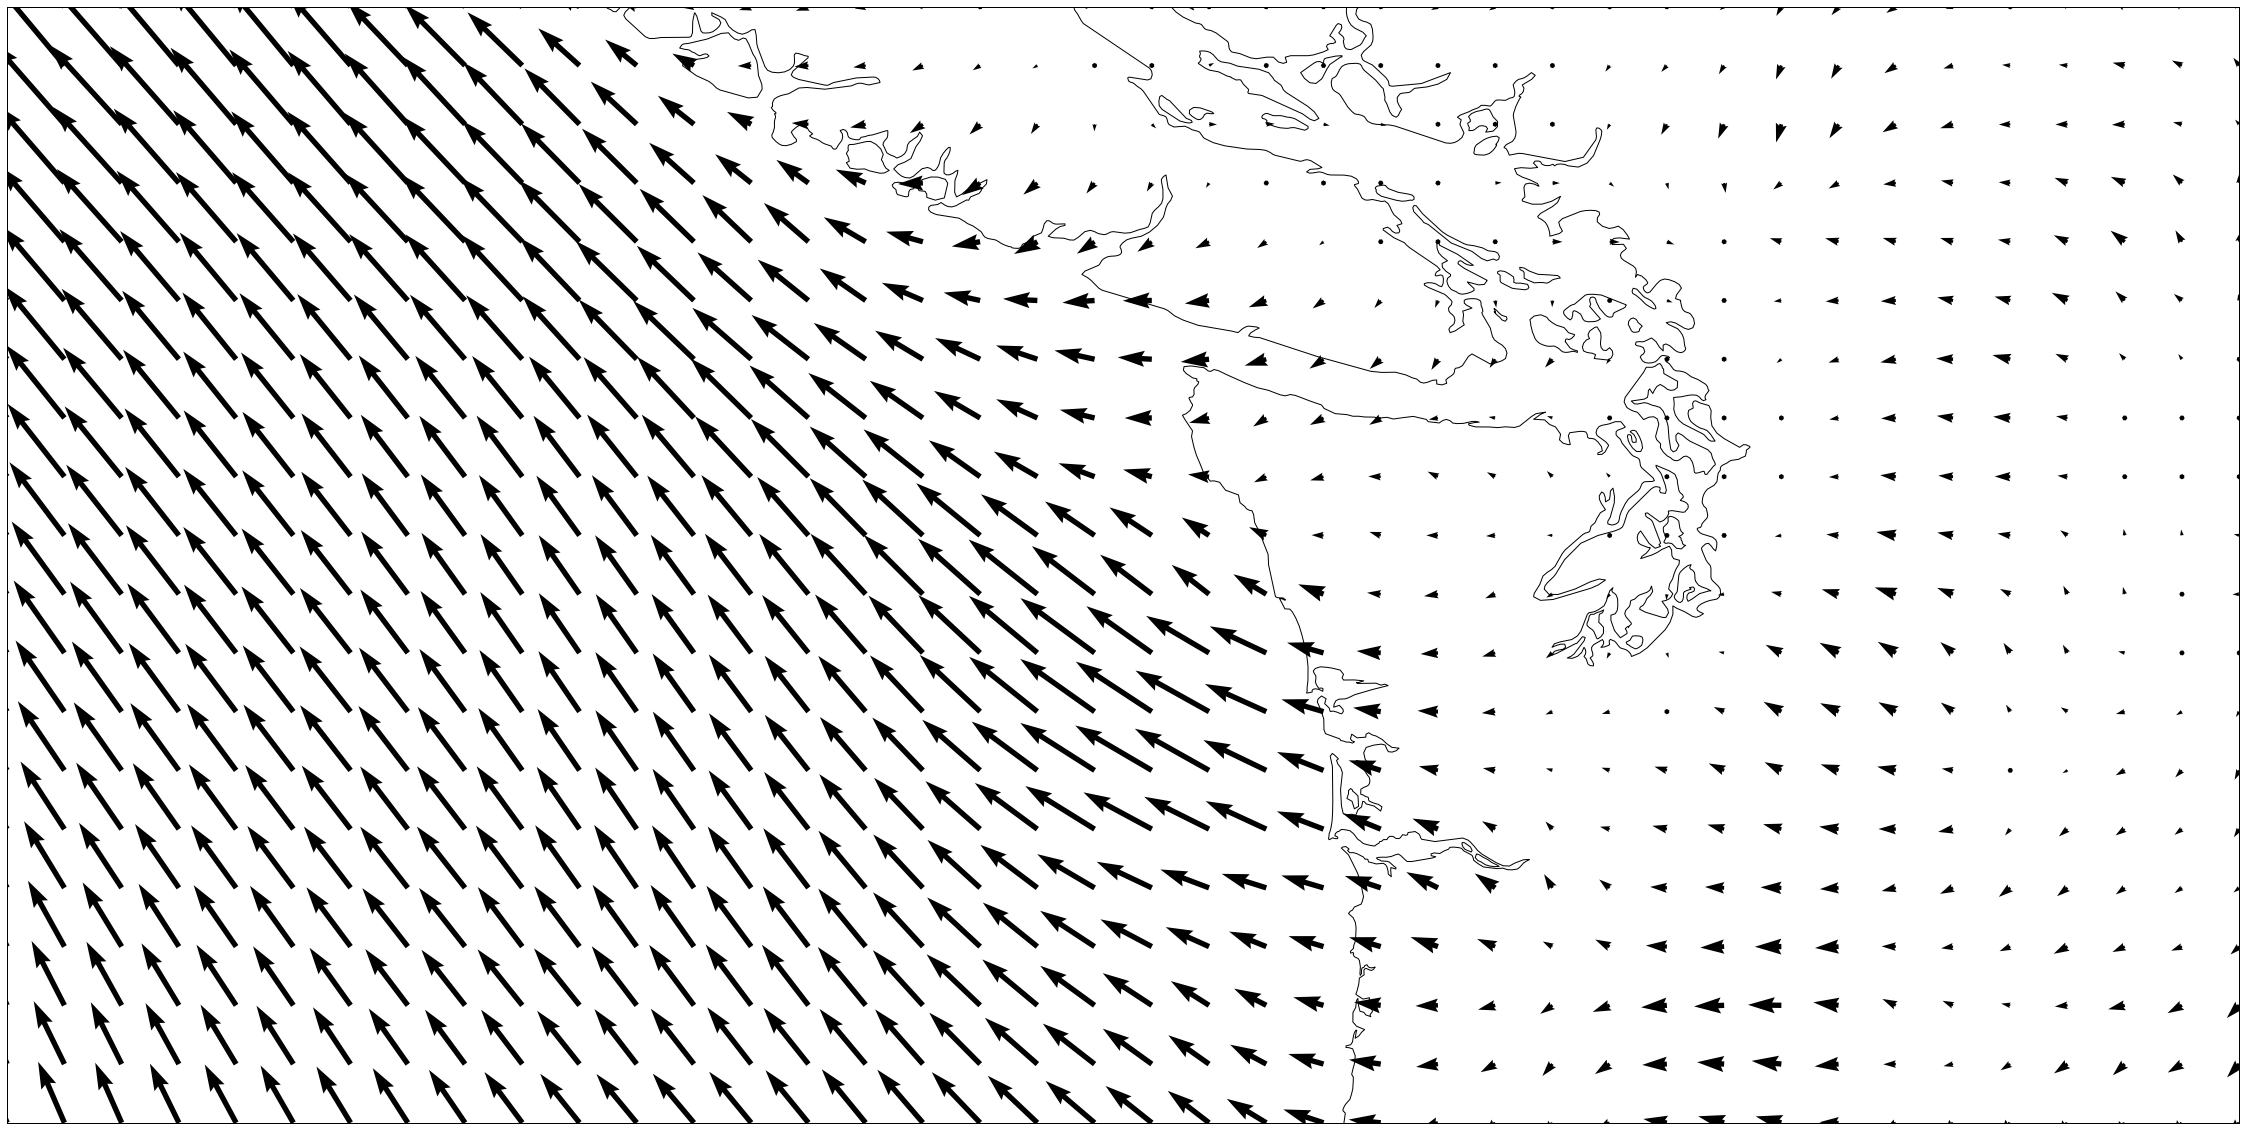

In [14]:
%matplotlib inline

plt.figure(figsize=(40,20))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines('10m')
ax.set_extent([-130, -120, 45, 50], ccrs.PlateCarree())
ax.quiver(x, y, u, v,  regrid_shape=20, **{'scale':300})

plt.show()

## Data Manipulation Using Xray & Pandas

In [15]:
dataraw = ncss.get_data_raw(query)
with open('tmp_grib', 'wb') as outf:
     outf.write(dataraw)

In [16]:
import xray

ndf = xray.open_dataset('./tmp_grib')
ndf

<xray.Dataset>
Dimensions:                                  (height_above_ground5: 3, lat: 61, lon: 121, time: 1)
Coordinates:
  * time                                     (time) datetime64[ns] 2016-01-02
  * height_above_ground5                     (height_above_ground5) float64 10.0 ...
  * lat                                      (lat) float64 50.0 49.5 49.0 ...
  * lon                                      (lon) float64 230.0 230.5 231.0 ...
Data variables:
    U-component_of_wind_height_above_ground  (time, height_above_ground5, lat, lon) float32 -9.47 ...
    V-component_of_wind_height_above_ground  (time, height_above_ground5, lat, lon) float32 12.09 ...
Attributes:
    Conventions: CF-1.0
    Originating_center: US National Weather Service - NCEP(WMC) (7)
    Generating_Model: Global Forecast System Model (formerly known as the Aviation)
    Product_Status: Operational products
    Product_Type: Forecast products
    title: US National Weather Service - NCEP(WMC) Global Forecast

In [17]:
ndf['U-component_of_wind_height_above_ground'].mean(['lat', 'lon'])

<xray.DataArray 'U-component_of_wind_height_above_ground' (time: 1, height_above_ground5: 3)>
array([[ 0.5291627 ,  1.28073144,  1.39978862]], dtype=float32)
Coordinates:
  * height_above_ground5  (height_above_ground5) float64 10.0 80.0 100.0
  * time                  (time) datetime64[ns] 2016-01-02

In [18]:
ndf['U-component_of_wind_height_above_ground'].max(['lat', 'lon'])

<xray.DataArray 'U-component_of_wind_height_above_ground' (time: 1, height_above_ground5: 3)>
array([[ 14.23999977,  15.88000011,  16.03000069]], dtype=float32)
Coordinates:
  * height_above_ground5  (height_above_ground5) float64 10.0 80.0 100.0
  * time                  (time) datetime64[ns] 2016-01-02

In [19]:
monthly_ncdf = xray.open_mfdataset('./201512/*fct:024.grb2', concat_dim='time')

In [20]:
monthly_ncdf

<xray.Dataset>
Dimensions:                                  (height_above_ground: 3, height_above_ground2: 1, height_above_ground3: 1, height_above_ground5: 3, lat: 2, lon: 2, pressure: 26, time: 74)
Coordinates:
  * height_above_ground2                     (height_above_ground2) float64 2.0
  * lat                                      (lat) float64 48.0 47.5
  * lon                                      (lon) float64 237.5 238.0
  * height_above_ground3                     (height_above_ground3) float64 80.0
  * height_above_ground5                     (height_above_ground5) float64 10.0 ...
  * pressure                                 (pressure) float64 1e+05 ...
  * height_above_ground                      (height_above_ground) float64 2.0 ...
  * time                                     (time) datetime64[ns] 2015-12-02 ...
Data variables:
    Dew_point_temperature                    (time, height_above_ground2, lat, lon) float32 278.3 ...
    Pressure_height_above_ground            

In [21]:
thtmeans = monthly_ncdf['U-component_of_wind_height_above_ground'].mean(['lat', 'lon', 'height_above_ground5'])

In [22]:
thtmeans.to_dataframe()

,U-component_of_wind_height_above_ground
time,
2015-12-02 00:00:00,-3.175833
2015-12-02 06:00:00,-2.867500
2015-12-02 12:00:00,-2.893333
2015-12-02 18:00:00,-2.309167
2015-12-03 00:00:00,-3.525000
2015-12-03 06:00:00,-5.040833
2015-12-03 12:00:00,-3.519167
2015-12-03 18:00:00,-5.461667
2015-12-05 06:00:00,-3.254167


In [67]:
monthly_ncdf.to_dataframe().head(10)

Dew_point_temperature  \
height_above_ground height_above_ground2 height_above_ground3 height_above_ground5 lat lon   pressure time                                         
2                   2                    80                   10                   48  237.5 100000   2015-12-02 00:00:00             278.299988   
                                                                                                      2015-12-02 06:00:00             278.200012   
                                                                                                      2015-12-02 12:00:00             277.899994   
                                                                                                      2015-12-02 18:00:00             279.299988   
                                                                                                      2015-12-03 00:00:00             280.399994   
                                                                                                      2015-12-03 06:00:00             277.799988   
                                                                                                      2015-12-03 12:00:00             280.000000   
                                                                                                      2015-12-03 18:00:00             279.799988   
                                                                                                      2015-12-05 06:00:00             278.399994   
                                                                                                      2015-12-05 12:00:00             276.899994   

                                                                                                                           Pressure_height_above_ground  \
height_above_ground height_above_ground2 height_above_ground3 height_above_ground5 lat lon   pressure time                                                
2                   2                    80                   10                   48  237.5 100000   2015-12-02 00:00:00                 100321.531250   
                                                                                                      2015-12-02 06:00:00                 100310.359375   
                                                                                                      2015-12-02 12:00:00                 100422.828125   
                                                                                                      2015-12-02 18:00:00                 100627.937500   
                                                                                                      2015-12-03 00:00:00                 100252.875000   
                                                                                                      2015-12-03 06:00:00                  99659.406250   
                                                                                                      2015-12-03 12:00:00                  99015.921875   
                                                                                                      2015-12-03 18:00:00                  98530.625000   
                                                                                                      2015-12-05 06:00:00                 100684.500000   
                                                                                                      2015-12-05 12:00:00                 100549.726562   

                                                                                                                           Temperature_height_above_ground  \
height_above_ground height_above_ground2 height_above_ground3 height_above_ground5 lat lon   pressure time                                                   
2                   2                    80                   10                   48  237.5 100000   2015-12-02 00:00:00                       282.329987   
           